For this exercise, I need to install tslearn, prophet and Neural Prophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
from fbprophet import Prophet

!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans

!pip install prophet
import prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

!pip install neuralprophet[live]
from neuralprophet import NeuralProphet

     |████████████████████████████████| 793 kB 13.4 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 216 kB 39.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640782 sha256=fee39c05463a8a7fd48eaa959be3d0b588d5c7b121b69a0351e68d3f51b02690
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
     |████████████████████████████████| 67 kB 4.6

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive')

Mounted at /content/gdrive


# Data analysis & preprocessing

The "online retail II" database contains all the transactions of an English company between 1 December 2009 and 9 December 2011. Most consumers are wholesalers. 

The database contains transactions for different products and different customers so each product can potentially be purchased by several customers. I decide to hide the customer part and my goal will be to predict the aggregated quantity ordered of each product. The first part aims to analyse the database and prepare the data. The second part aims to create clusters of time series in order to draw the most representative persona of each cluster and to predict the quantity for each of them in the third part. I will therefore rely on the Prophet and Neural Prophet algorithms.

The use of clusters in our approach is useful because the computation time of Prophet does not allow us to apply it on the 200 time series I will work on. Moreover, the clustering step will aim at grouping the series that share the same characteristics such as their seasonality, this will be efficient in the application of the Prophet algorithm that will predict on the persona, i.e. a representative series of the cluster.

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/DATA/online_retail_II.csv', delimiter = ";")

Let us see which countries are concerned about the data.

In [ ]:
df_plt1 = (df[['Country', 'Quantity']]
 .groupby('Country')
 .count()
 .reset_index()
 .sort_values('Quantity', ascending = False)
 .assign(PropPurchase = lambda x: x.Quantity / len(df))
 .reset_index(drop=True, inplace=False)
 .loc[:, ['Country', 'PropPurchase']])

df_plt1 = df_plt1.loc[0:5].append({'Country': "Other", 'PropPurchase' : df_plt1.loc[6:, 'PropPurchase'].sum()}, ignore_index=True)

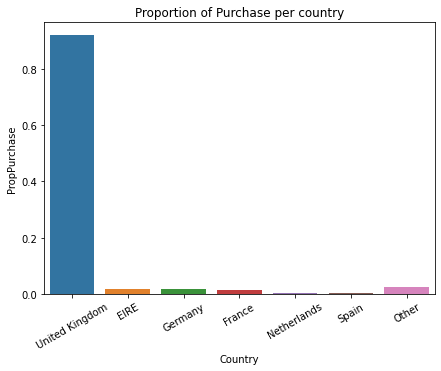

In [ ]:
plt.figure(figsize=(7, 5))
plt1 = sns.barplot(x = 'Country', y = 'PropPurchase', data = df_plt1)
plt1.set_title('Proportion of Purchase per country')
plt.xticks(rotation=30)
plt.show()

As shown in the last graph, United Kingdom represents 91% of all the purchases in the dataset. I decide then only to keep purchases from this country.

In [ ]:
df = (df
 .loc[df.Country == "United Kingdom", ['StockCode', 'Quantity', 'InvoiceDate']] # Only keep data from United Kingdom
 .rename(columns={"StockCode": "produit", "Quantity": "y", "InvoiceDate" : "ds"}) # Rename variable to be complient with Prophet
 .assign(ds = lambda x: pd.to_datetime(x.ds).dt.date)) # Reformate date in order to remove the hour

The next tables shows that some quantity are negative. I decide to remove this observations.

In [ ]:
df[df.y < 0]

,produit,y,ds
196,90200A,-3,2009-01-12
197,90200D,-3,2009-01-12
198,90200B,-3,2009-01-12
199,90200E,-3,2009-01-12
200,90200C,-3,2009-01-12
...,...,...,...
1043433,23144,-11,2011-09-12
1044525,M,-1,2011-09-12
1044699,21258,-5,2011-09-12
1044700,84978,-1,2011-09-12


In [ ]:
df = df[df.y > 0]

Because multiple purchases can be done each day, we must aggregate the quantities per day.

In [ ]:
df = (df.groupby(['produit', 'ds']) 
 .agg({'y': 'sum'}) # I sum the quantity purchased by product and by day.
 .reset_index())

Let us focus on the period to be studied.

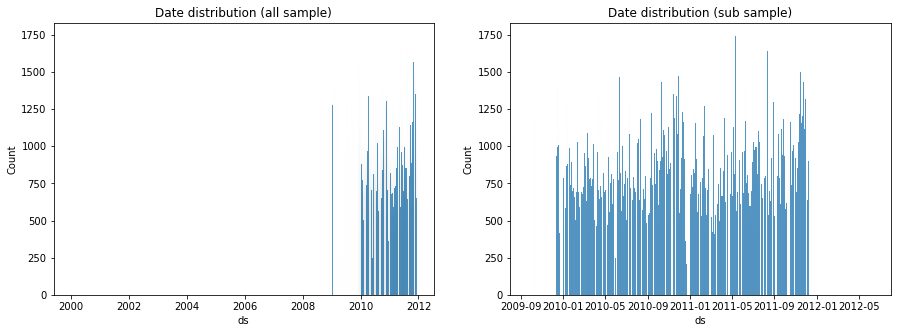

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

plt2 = sns.histplot(ax=axes[0], x = 'ds', data = df)
plt2.set_title('Date distribution (all sample)')

plt3 = sns.histplot(ax=axes[1], x = 'ds', data = df[df.ds > pd.to_datetime('2009-08-01')])
plt3.set_title('Date distribution (sub sample)')
plt.xlim([pd.to_datetime('2009-08-01'), pd.to_datetime('2012-08-01')])
plt.show()

As it is shown in the previous graphs, almost all purchases are made between december 2009 and december 2011.

In [ ]:
df = df.loc[(df.ds > pd.to_datetime('2009-12-01')) & (df.ds < pd.to_datetime('2012-12-01'))]

The following graph shows the distribution of product popularity. For example, almost 1200 products are purchased only one time in the period 01/12/2009 to 01/12/2009. I decide to keep only the 200 products that are the more popular in the database.

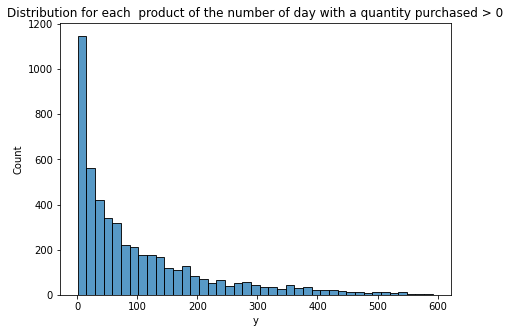

In [ ]:
df_plt3 = (df
 .groupby('produit')
 .count()
 .sort_values('y', ascending = False))

plt.figure(figsize=(7, 5))

plt4 = sns.histplot(x = 'y', data = df_plt3)
plt4.set_title('Distribution for each  product of the number of day with a quantity purchased > 0')
plt.show()

In [ ]:
top_prod = (df_plt3
 .reset_index()
 .loc[range(0, 200), 'produit'])

df = (df[df.produit.isin(top_prod)])

The database only contains observations where the quantities are higher than 0, but it does not include the days where the quantity observed is zero. The next code allows to complete the database.

In [ ]:
df = (df
 .set_index(['ds', 'produit'])
 .unstack(fill_value=0)
 .asfreq('D', fill_value=0)
 .stack()
 .sort_index(level=1)
 .reset_index())

The next graphs shows example of series.

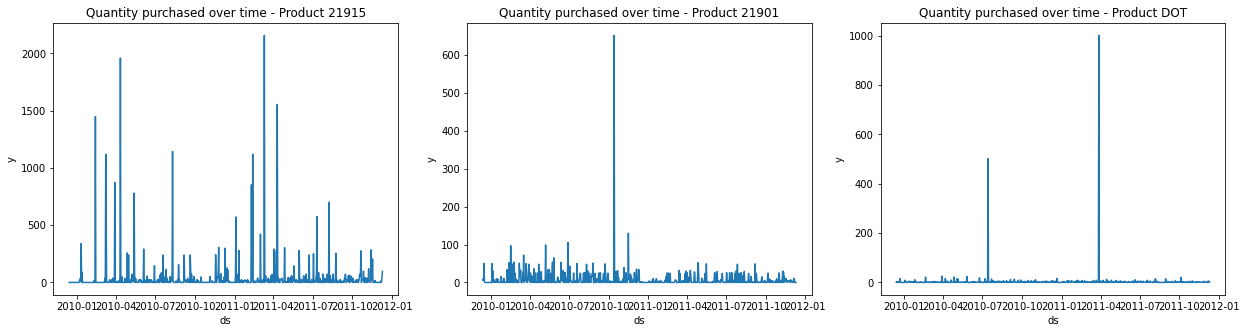

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(21,5))

plt5 =sns.lineplot(ax = axes[0], x='ds', y='y', data=df[df.produit == '21915'], palette = 'Set2')
plt5.set_title('Quantity purchased over time - Product 21915')

plt6 = sns.lineplot(ax = axes[1], x='ds', y='y', data=df[df.produit == '21901'], palette = 'Set2')
plt6.set_title('Quantity purchased over time - Product 21901')

plt7 = sns.lineplot(ax = axes[2], x='ds', y='y', data=df[df.produit == 'DOT'], palette = 'Set2')
plt7.set_title('Quantity purchased over time - Product DOT')
plt.show()

Because there are a lot of variation in the data, I decide to compute the rolling mean over 20 days : this will be the variable we will want to predict.

In [ ]:
df['y'] = (df
           .groupby('produit')['y']
            .rolling(40)
            .mean()
            .reset_index()
            .y)

The next graphs shows that the series are much less volatile. We can expect to have more facilities to detect the trend and the seasonalities.

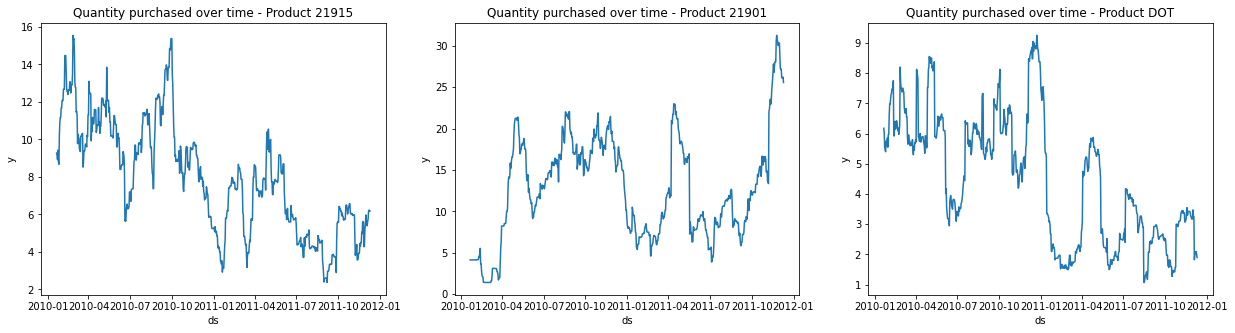

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(21,5))

plt5 =sns.lineplot(ax = axes[0], x='ds', y='y', data=df[df.produit == '22227'], palette = 'Set2')
plt5.set_title('Quantity purchased over time - Product 21915')

plt6 = sns.lineplot(ax = axes[1], x='ds', y='y', data=df[df.produit == '22561'], palette = 'Set2')
plt6.set_title('Quantity purchased over time - Product 21901')

plt7 = sns.lineplot(ax = axes[2], x='ds', y='y', data=df[df.produit == '20754'], palette = 'Set2')
plt7.set_title('Quantity purchased over time - Product DOT')
plt.show()

To increase the efficiency of the clusters, I decide to centre and reduce the time series. Thus, clusters will be built more by taking into account the seasonality rather than the level of the time series.

In [ ]:
df['y'] = df.groupby('produit').transform(lambda x: (x - x.mean()) / x.std())

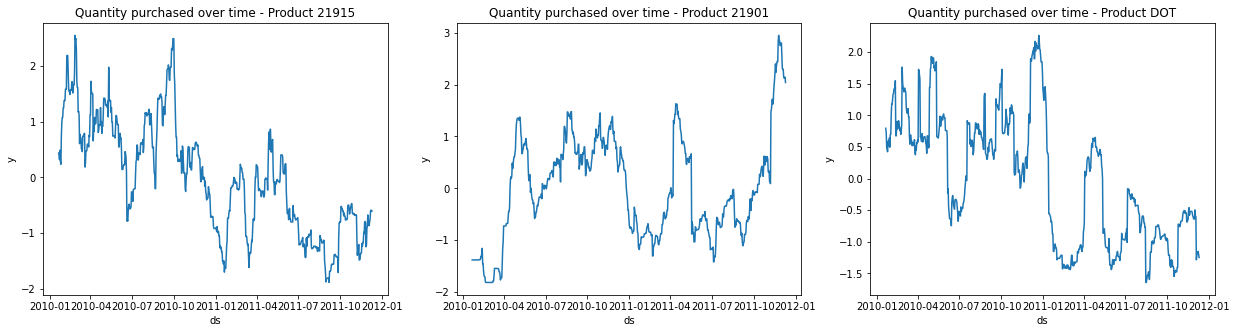

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(21,5))

plt5 =sns.lineplot(ax = axes[0], x='ds', y='y', data=df[df.produit == '22227'], palette = 'Set2')
plt5.set_title('Quantity purchased over time - Product 21915')

plt6 = sns.lineplot(ax = axes[1], x='ds', y='y', data=df[df.produit == '22561'], palette = 'Set2')
plt6.set_title('Quantity purchased over time - Product 21901')

plt7 = sns.lineplot(ax = axes[2], x='ds', y='y', data=df[df.produit == '20754'], palette = 'Set2')
plt7.set_title('Quantity purchased over time - Product DOT')
plt.show()

# Time series clustering

For the next steps, I split the dataset into two subsamples : the train and test samples. To do so, I assume that I know only the observations before 01/09/2011. The observations after this date will be used to test the quality of a model.

In [ ]:
test = df[df.ds >= '2011-09-01']
df = df[df.ds < '2011-09-01'].dropna()

In order to create cluster of times series, we must pivot the table such that each observation corresponds to a serie. Thus, I will try to make groups of series, through a base clustering algorithm, that are different from each other and whose observations within these groups are similar to each other.

In [ ]:
df_clus = df.pivot(index = 'produit', columns = 'ds', values = 'y')
df_clus

ds,2010-01-21,2010-01-22,2010-01-23,2010-01-24,2010-01-25,2010-01-26,2010-01-27,2010-01-28,2010-01-29,2010-01-30,2010-01-31,2010-02-01,2010-02-02,2010-02-03,2010-02-04,2010-02-05,2010-02-06,2010-02-07,2010-02-08,2010-02-09,2010-02-10,2010-02-11,2010-02-12,2010-02-13,2010-02-14,2010-02-15,2010-02-16,2010-02-17,2010-02-18,2010-02-19,2010-02-20,2010-02-21,2010-02-22,2010-02-23,2010-02-24,2010-02-25,2010-02-26,2010-02-27,2010-02-28,2010-03-01,...,2011-07-23,2011-07-24,2011-07-25,2011-07-26,2011-07-27,2011-07-28,2011-07-29,2011-07-30,2011-07-31,2011-08-01,2011-08-02,2011-08-03,2011-08-04,2011-08-05,2011-08-06,2011-08-07,2011-08-08,2011-08-09,2011-08-10,2011-08-11,2011-08-12,2011-08-13,2011-08-14,2011-08-15,2011-08-16,2011-08-17,2011-08-18,2011-08-19,2011-08-20,2011-08-21,2011-08-22,2011-08-23,2011-08-24,2011-08-25,2011-08-26,2011-08-27,2011-08-28,2011-08-29,2011-08-30,2011-08-31
produit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15036,-0.713929,-0.711199,-0.745326,-0.720754,-0.722119,-0.713246,-0.705738,-0.705738,-0.689358,-0.689358,-0.758976,-0.759659,-0.759659,-0.718707,-0.718707,-0.669564,-0.493470,-0.485279,-0.460708,-0.460708,-0.460708,-0.466168,-0.499613,-0.925515,-0.925515,-0.917325,-0.976023,-0.959642,-0.894801,-0.894801,-0.900261,-0.900261,-0.885246,-0.898214,-0.887293,-0.844976,-0.844293,-0.844976,-0.881150,-0.897531,...,-0.217725,-0.157662,-0.159710,-0.651818,-0.676389,-0.676389,-0.291439,-0.303725,-0.321471,-0.346042,-0.370613,-0.378804,-0.339899,-0.339899,0.094194,0.086004,0.094194,0.159717,0.156305,0.162448,0.137194,0.104432,0.104432,0.011607,0.006829,-0.001361,0.011607,0.011607,0.011607,0.019798,0.019798,-0.013647,-0.015694,-0.007504,-0.048456,-0.166535,-0.158344,-0.208170,-0.193836,-0.208170
15056N,-0.672960,-0.672960,-0.723767,-1.028610,-1.001252,-1.012977,-1.012977,-0.993436,-0.989528,-1.036426,-1.032518,-1.032518,-1.020794,-0.977803,-0.977803,-0.977803,-0.938720,-0.813657,-0.524447,-0.500998,-0.500998,-0.442374,-0.493181,-0.524447,-0.524447,-0.563530,-0.571346,-0.563530,-0.583071,-0.579162,-0.583071,-0.778483,-0.758941,-0.981711,-0.837106,-0.356393,-0.426741,-0.426741,-0.418925,-0.426741,...,-0.180522,0.276742,0.300191,0.315824,0.308008,0.331457,-0.149256,-0.223513,-0.301677,-0.418925,-0.407200,-0.454099,-0.438466,-0.434558,-0.375934,-0.364209,-0.289953,-0.297769,-0.313402,-0.309494,-0.313402,-0.317310,-0.317310,-0.282136,-0.286045,-0.270412,-0.078908,0.139954,0.136045,0.139954,0.386173,0.421347,0.616759,0.675382,0.659749,0.421347,0.261109,0.245476,0.018798,-0.078908
20676,-1.380344,-1.437005,-1.556623,-1.052969,-1.052969,-0.971125,-0.983716,-0.731889,-0.719298,-0.719298,-0.599680,-0.599680,-0.599680,-0.593384,-0.593384,-0.492653,-0.442288,-0.272304,-0.272304,-0.272304,-0.272304,-0.177869,-0.102321,-0.152686,-0.102321,0.073958,-0.077138,-0.051955,-0.303783,-0.310078,-0.366739,-0.347852,-0.291191,-0.297487,-0.272304,0.231350,0.168393,0.143211,0.212463,0.180985,...,0.092845,0.615387,0.583908,0.621683,0.621683,0.634274,0.596500,0.502065,0.451699,0.300603,0.262829,0.250237,0.256533,0.256533,-0.007886,-0.001590,-0.026773,-0.033068,-0.033068,-0.568201,-0.731889,-0.731889,-0.731889,-0.857803,-1.304796,-1.178882,-1.185178,-1.185178,-1.267022,-1.317387,-1.323683,-1.399231,-0.442288,-0.435992,-0.435992,-0.543018,-0.593384,-0.605975,-0.593384,-0.587088
20677,-1.448187,-1.427198,-1.500661,0.178503,0.126029,0.136523,0.042070,0.377903,0.377903,0.377903,1.133527,1.133527,1.175506,1.196496,1.196496,1.385401,1.437875,1.637276,1.647771,1.731729,1.731729,1.721234,1.721234,1.721234,1.721234,1.815687,1.553318,1.742224,1.154516,1.154516,1.112537,1.123032,1.112537,0.944621,0.955116,1.123032,1.091548,1.049569,1.112537,1.091548,...,0.734726,1.133527,1.133527,1.217485,1.154516,1.175506,1.112537,1.112537,1.112537,1.112537,1.186001,1.941624,1.941624,1.941624,2.256468,2.235478,2.183004,2.203994,1.941624,1.805192,1.815687,1.794698,1.794698,0.955116,0.168008,0.209987,0.209987,0.094544,0.010586,-0.640090,-0

By comparing different time series clustering methods, I finally choose to use Kmeans which seems to be more efficient to determine a representative persona cluster. I decide to apply a kmeans with k = 6.

In [ ]:
n_clusters = 6

In [ ]:
clus = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10, n_init=2).fit(df_clus)

The next code shows us the number of series in eahc cluster.

In [ ]:
pd.value_counts(clus.labels_)

5    42
4    39
2    33
1    31
3    29
0    26
dtype: int64

In [ ]:
personas = pd.DataFrame(clus.cluster_centers_.reshape(n_clusters, len(df_clus.columns)))
personas.columns = df_clus.columns
personas = (personas
            .transpose()
            .unstack()
            .reset_index()
            .rename(columns={"level_0": "cluster", 0: "y"}))

In [ ]:
tab_clus = pd.DataFrame({'produit': df_clus.index, 'cluster': clus.labels_})

df1 = df.merge(tab_clus, on = 'produit')
test1 = test.merge(tab_clus, on = 'produit')

The following graph shows each of the 6 personas. They are supposed to be quite different from each other.

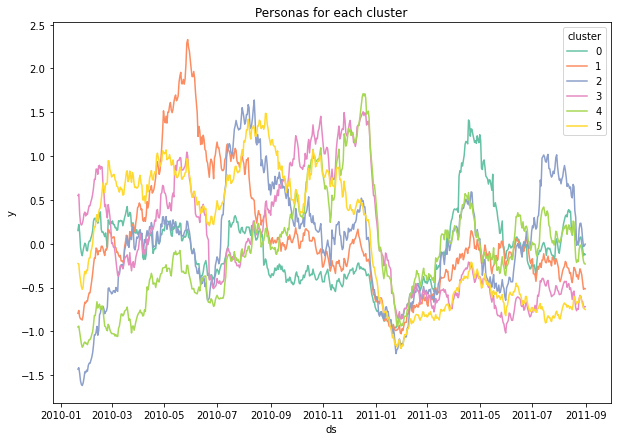

In [ ]:
plt.figure(figsize=(10, 7))

plt8 = sns.lineplot(x='ds', y='y', hue='cluster', data=personas, palette = 'Set2')
plt8.set_title('Personas for each cluster')
plt.show()

The following 6 graphs compare each persona with 3 randomly chosen time series. This shows that the personas are representative of the clusters to which they correspond.

In [ ]:
ech = {}
for i in range(0, 6):
  ech[i] = df1.loc[df1.cluster == i].produit.unique()[0:3]

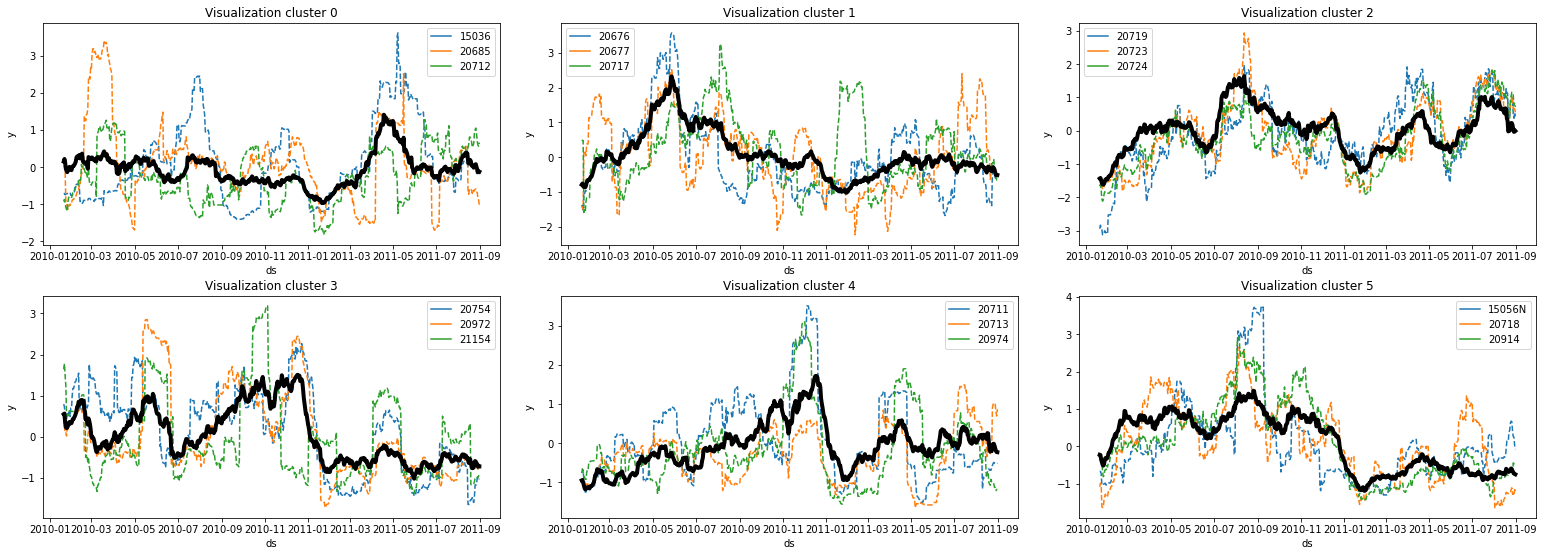

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(22,8))
fig.tight_layout(pad = 3.0)

for i, ax in zip(range(6), axes.flat):
    a = sns.lineplot(ax=ax, x='ds', y='y', hue='produit', data=df1[df1.produit.isin(ech[i])], linestyle = "dashed")
    a = sns.lineplot(ax=ax, x='ds', y='y', data=personas[personas.cluster == i], lw = 4, color = "black")
    a.set_title('Visualization cluster ' + str(i))
plt.show()

# Predict with prophet

In the first part, I will predict the quantities purchased using Facebook's Prophet model.

## Fit and predict

The following code is used to train the algorithm on the training sample and to predict the quantities purchased on the test sample. The loop allows this to be repeated for each persona.

In [ ]:
pred = {}
for i in range(0, 6):
  m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
  m.fit(personas.loc[personas.cluster == i, ['ds', 'y']])
  future = m.make_future_dataframe(periods=15*7, freq = 'D')
  pred[i] = m.predict(future).loc[m.predict(future).ds >= '2011-09-11', ['ds', 'yhat']]

## Visualization

As you can see from the following graph, the red curve represents the prediction of the algorithm that trained on the black curve. We can see that the predictions are more or less far from reality.

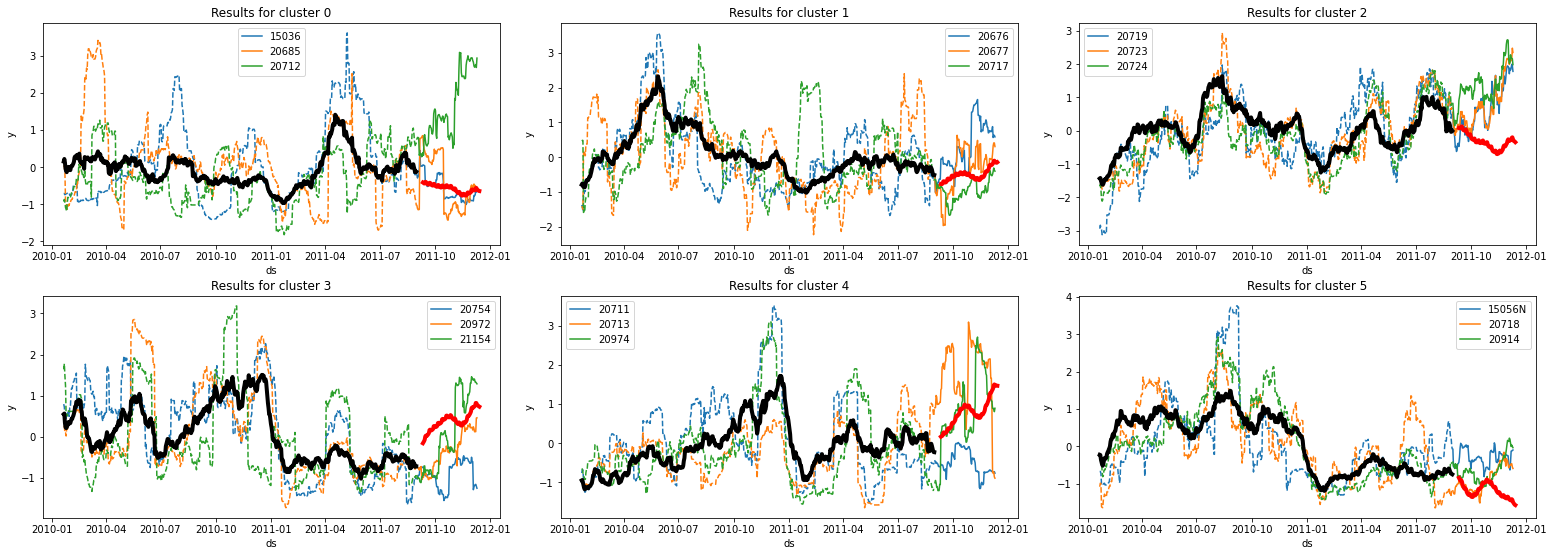

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(22,8))
fig.tight_layout(pad = 3.0)

for i, ax in zip(range(6), axes.flat):
    a = sns.lineplot(ax = ax, x='ds', y='y', hue = 'produit', data=df1[df1.produit.isin(ech[i])], linestyle = "dashed", legend = False)
    a = sns.lineplot(ax=ax, x='ds', y='y', hue = 'produit', data=test1[test1.produit.isin(ech[i])])
    a = sns.lineplot(ax=ax, x='ds', y='yhat', data = pred[i], lw = 4, color = "red")
    a = sns.lineplot(ax=ax, x='ds', y='y', data=personas[personas.cluster == i], lw = 4, color = "black")
    a.set_title('Results for cluster ' + str(i))
plt.show()

## Evaluation

To evaluate the model, I use the metric of the sum of squared residuals. We can see from the following table that the "best" predicted series has an SSR of 0.03 while the "worst" predicted series has an SSR of 8.11.

In [ ]:
res = {}
for i in range(0, 6):
  res[i] = pd.merge(test1[test1.cluster == i], pred[i], on = 'ds')

all_res = pd.concat([res[0], res[1], res[2], res[3], res[4], res[5]])

all_res['residual'] = all_res['y'] - all_res['yhat']
all_res['square_res'] =all_res['residual']**2

(all_res
 .groupby(['produit'])
 .agg({'square_res' : 'mean'})
 .reset_index()
 .sort_values('square_res'))

,produit,square_res
14,20726,0.026569
25,21094,0.040273
123,22384,0.041699
199,DOT,0.050301
0,15036,0.053399
...,...,...
35,21175,5.549894
153,48185,5.883815
6,20712,6.031997
185,84988,7.166409


Since we have centred and reduced the time series, it seems correct to me to average the squared residuals over each time series. The following table shows this average SRH for each cluster. Some disparities can be observed.

In [ ]:
(all_res
 .groupby(['cluster'])
 .agg({'square_res' : 'mean'})
 .reset_index()
 .sort_values('square_res'))

,cluster,square_res
1,1,0.544637
3,3,0.884929
5,5,0.903339
2,2,0.914264
4,4,0.982381
0,0,2.527118


The average squared residual over all time series is 1.07

In [ ]:
all_res['square_res'].mean()

1.0733778186562075

# Predict with Neural Prophet

In this section I will attempt to predict the quantity ordered using Neural Prophet. This will allow me to compare the results with those of Prophet.

## Fit and predict

In [ ]:
pred = {}
for i in range(0, 6):
  m = NeuralProphet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
  m.fit(personas.loc[personas.cluster == i, ['ds', 'y']], freq="D")
  future = m.make_future_dataframe(personas.loc[personas.cluster == i, ['ds', 'y']], periods=15*7)
  pred[i] = m.predict(future).loc[m.predict(future).ds >= '2011-09-11', ['ds', 'yhat1']]

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 206
INFO:NP.config:Auto-set epochs to 206


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.30E-01, min: 4.42E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.30E-01, min: 4.42E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.16E-02, min: 4.42E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.16E-02, min: 4.42E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.40E-02, min: 3.40E-01
INFO:NP.utils_torch:lr-range-test results: steep: 8.40E-02, min: 3.40E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.00E-01
Epoch[206/206]: 100%|██████████| 206/206 [00:17<00:00, 11.48it/s, SmoothL1Loss=0.00244, MAE=0.0954, RMSE=0.122, RegLoss=0]
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 206
INFO:NP.config:Auto-set epochs to 206


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.69E-02, min: 6.85E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.69E-02, min: 6.85E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.46E-02, min: 8.15E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.46E-02, min: 8.15E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.46E-02, min: 6.85E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.46E-02, min: 6.85E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.85E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.85E-02
Epoch[206/206]: 100%|██████████| 206/206 [00:18<00:00, 11.41it/s, SmoothL1Loss=0.00114, MAE=0.0934, RMSE=0.12, RegLoss=0]
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 206
INFO:NP.config:Auto-set epochs to 206


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.47E-02, min: 9.71E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.47E-02, min: 9.71E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.47E-02, min: 9.71E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.47E-02, min: 9.71E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.47E-02, min: 1.26E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.47E-02, min: 1.26E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.47E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 2.47E-02
Epoch[206/206]: 100%|██████████| 206/206 [00:18<00:00, 11.41it/s, SmoothL1Loss=0.00228, MAE=0.148, RMSE=0.184, RegLoss=0]
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 206
INFO:NP.config:Auto-set epochs to 206


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 7.47E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.92E-02, min: 7.47E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 8.15E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.92E-02, min: 8.15E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 1.06E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.92E-02, min: 1.06E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.92E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.92E-02
Epoch[206/206]: 100%|██████████| 206/206 [00:17<00:00, 11.58it/s, SmoothL1Loss=0.00273, MAE=0.134, RMSE=0.168, RegLoss=0]
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 206
INFO:NP.config:Auto-set epochs to 206


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.21E-02, min: 1.38E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.21E-02, min: 1.38E+00


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.50E-02, min: 8.90E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.50E-02, min: 8.90E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.94E-02, min: 1.79E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.94E-02, min: 1.79E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.21E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.21E-02
Epoch[206/206]: 100%|██████████| 206/206 [00:18<00:00, 11.32it/s, SmoothL1Loss=0.00233, MAE=0.127, RMSE=0.157, RegLoss=0]
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 206
INFO:NP.config:Auto-set epochs to 206


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.94E-02, min: 9.71E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.94E-02, min: 9.71E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.21E-02, min: 8.90E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.21E-02, min: 8.90E-01


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.21E-02, min: 8.90E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.21E-02, min: 8.90E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.12E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.12E-02
Epoch[206/206]: 100%|██████████| 206/206 [00:18<00:00, 11.40it/s, SmoothL1Loss=0.00119, MAE=0.0944, RMSE=0.114, RegLoss=0]


## Visualization

As for the Prophet algorithm, here is the visualisation of the results for Neural Prophet.

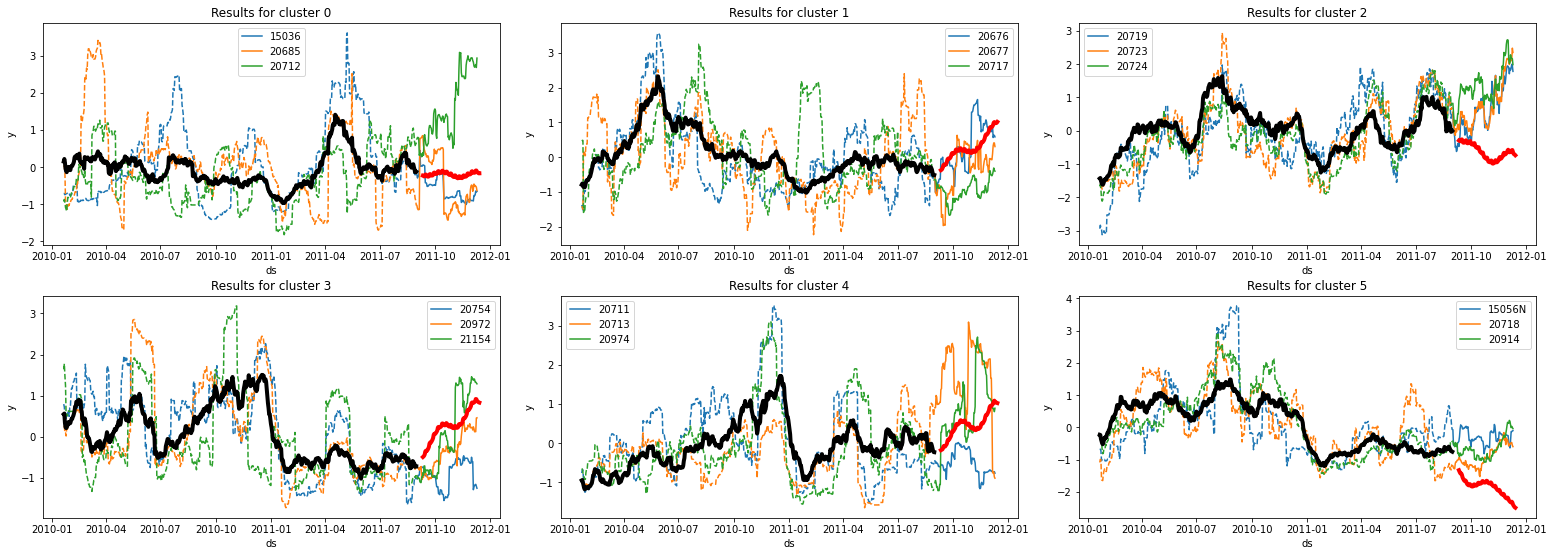

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(22,8))
fig.tight_layout(pad = 3.0)

for i, ax in zip(range(6), axes.flat):
    a = sns.lineplot(ax = ax, x='ds', y='y', hue = 'produit', data=df1[df1.produit.isin(ech[i])], linestyle = "dashed", legend = False)
    a = sns.lineplot(ax=ax, x='ds', y='y', hue = 'produit', data=test1[test1.produit.isin(ech[i])])
    a = sns.lineplot(ax=ax, x='ds', y='yhat1', data = pred[i], lw = 4, color = "red")
    a = sns.lineplot(ax=ax, x='ds', y='y', data=personas[personas.cluster == i], lw = 4, color = "black")
    a.set_title('Results for cluster ' + str(i))
plt.show()

## Evaluation

The evaluation of the model shows us that Neural Prophet does not seem to have done better than Prophet since the average squared residual over all time series is 1.35 whereas it was 1.07 for Prophet.

In [ ]:
res = {}
for i in range(0, 6):
  res[i] = pd.merge(test1[test1.cluster == i], pred[i], on = 'ds')

all_res = pd.concat([res[0], res[1], res[2], res[3], res[4], res[5]])

all_res['residual'] = all_res['y'] - all_res['yhat1']
all_res['square_res'] =all_res['residual']**2

(all_res
 .groupby(['produit'])
 .agg({'square_res' : 'mean'})
 .reset_index()
 .sort_values('square_res'))

,produit,square_res
199,DOT,0.033609
179,84879,0.079289
159,82482,0.094363
145,22629,0.112843
161,82484,0.114155
...,...,...
151,48138,5.840919
185,84988,6.159675
96,22138,6.190681
78,21930,7.381709


In [ ]:
(all_res
 .groupby(['cluster'])
 .agg({'square_res' : 'mean'})
 .reset_index()
 .sort_values('square_res'))

,cluster,square_res
3,3,0.727320
4,4,0.913477
1,1,1.080421
2,2,1.122027
0,0,1.919538
5,5,2.200134


In [ ]:
all_res['square_res'].mean()

1.3477573698826222

# Improved Prophet

In this part, I decide to go a little further by optimising some parameters of the Prophet algorithm. On the advice of the Prophet authors, two parameters that seem to have a significant impact on the quality of the results are the changepoint_prior_scale and seasonality_prior_scale parameters. Therefore, I use cross-validation to optimise these parameters.

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for clus_ in range(0, 6):
  for params in all_params:
    m = Prophet(**params, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True).fit(personas.loc[personas.cluster == clus_, ['ds', 'y']])  
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.concat([pd.DataFrame(all_params)]*6)
tuning_results['clus'] = np.repeat(range(0, 6), 16)
tuning_results['rmse'] = rmses
tuning_results = tuning_results.reset_index(drop=True)
print(tuning_results)

INFO:prophet:Making 13 forecasts with cutoffs between 2011-02-02 00:00:00 and 2011-08-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f3843ec8bd0>
INFO:prophet:Making 13 forecasts with cutoffs between 2011-02-02 00:00:00 and 2011-08-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f3843d8c790>
INFO:prophet:Making 13 forecasts with cutoffs between 2011-02-02 00:00:00 and 2011-08-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f38576d2550>
INFO:prophet:Making 13 forecasts with cutoffs between 2011-02-02 00:00:00 and 2011-08-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f3849ce45d0>
INFO:prophet:Making 13 forecasts with cutoffs between 2011-02-02 00:00:00 and 2011-08-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures

    changepoint_prior_scale  seasonality_prior_scale  clus      rmse
0                     0.001                     0.01     0  0.759001
1                     0.001                     0.10     0  0.695723
2                     0.001                     1.00     0  0.694431
3                     0.001                    10.00     0  0.694597
4                     0.010                     0.01     0  0.746607
..                      ...                      ...   ...       ...
91                    0.100                    10.00     5  0.466514
92                    0.500                     0.01     5  0.472048
93                    0.500                     0.10     5  0.451244
94                    0.500                     1.00     5  0.481071
95                    0.500                    10.00     5  0.490368

[96 rows x 4 columns]


The following graphs allow us to visualise the results using the optimised parameters.

In [ ]:
best_params = tuning_results.loc[(tuning_results.
                                  groupby('clus')
                                  .rmse
                                  .idxmin())].reset_index(drop = True)

pred = {}
for i in range(0, 6):
  m = Prophet(changepoint_prior_scale=best_params.loc[best_params.clus == i, 'changepoint_prior_scale'],
              seasonality_prior_scale=best_params.loc[best_params.clus == i, 'seasonality_prior_scale'],
              yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True) 
  m.fit(personas.loc[personas.cluster == i, ['ds', 'y']])
  future = m.make_future_dataframe(periods=15*7, freq = 'D')
  pred[i] = m.predict(future).loc[m.predict(future).ds >= '2011-09-11', ['ds', 'yhat']]

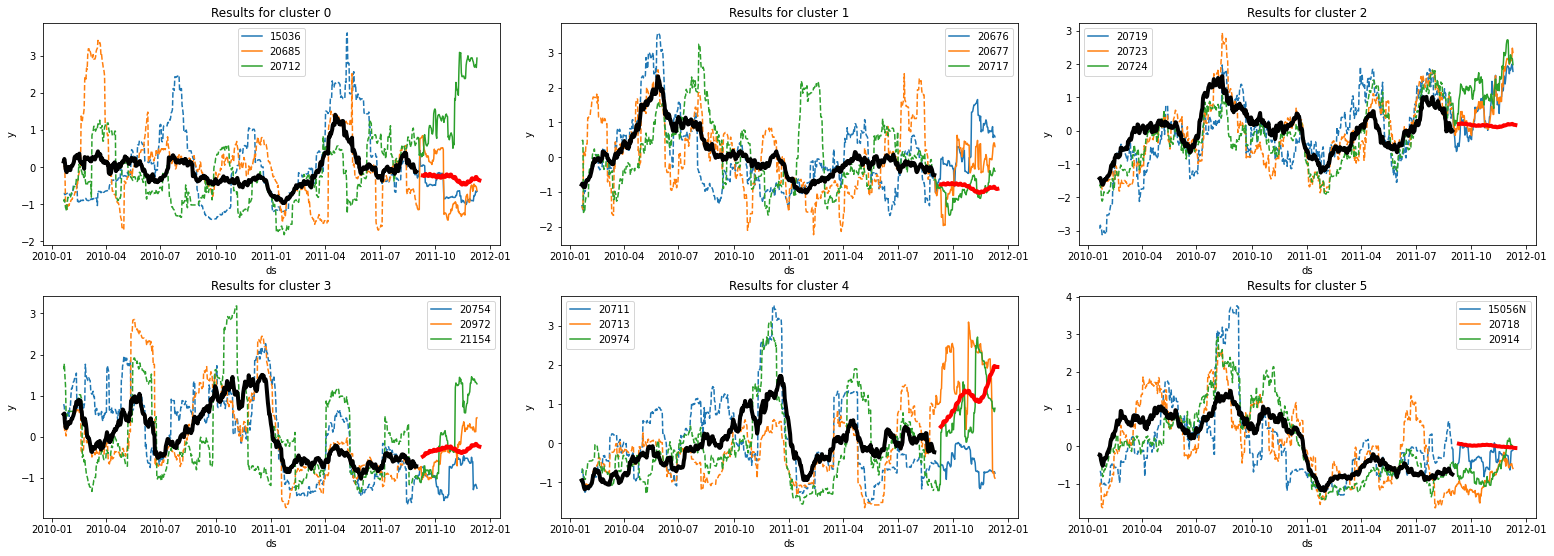

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(22,8))
fig.tight_layout(pad = 3.0)

for i, ax in zip(range(6), axes.flat):
    a = sns.lineplot(ax = ax, x='ds', y='y', hue = 'produit', data=df1[df1.produit.isin(ech[i])], linestyle = "dashed", legend = False)
    a = sns.lineplot(ax=ax, x='ds', y='y', hue = 'produit', data=test1[test1.produit.isin(ech[i])])
    a = sns.lineplot(ax=ax, x='ds', y='yhat', data = pred[i], lw = 4, color = "red")
    a = sns.lineplot(ax=ax, x='ds', y='y', data=personas[personas.cluster == i], lw = 4, color = "black")
    a.set_title('Results for cluster ' + str(i))
plt.show()

The following code allows us to conclude that the optimization has reduced the average square of the residuals on each series from 1.07 to 1.03.

In [ ]:
res = {}
for i in range(0, 6):
  res[i] = pd.merge(test1[test1.cluster == i], pred[i], on = 'ds')

all_res = pd.concat([res[0], res[1], res[2], res[3], res[4], res[5]])

all_res['residual'] = all_res['y'] - all_res['yhat']
all_res['square_res'] =all_res['residual']**2

(all_res
 .groupby(['cluster'])
 .agg({'square_res' : 'mean'})
 .reset_index()
 .sort_values('square_res'))

,cluster,square_res
3,3,0.541579
1,1,0.720016
5,5,0.765495
2,2,0.938106
4,4,1.296809
0,0,2.059374


In [ ]:
all_res['square_res'].mean()

1.0262694232867127

# Conclusion

In conclusion, this study allowed us to use time series clustering to predict the quantity ordered for each product of a company. This approach is obviously useful from a marketing point of view since companies selling a panel of products are potentially interested in having an estimate of the quantity ordered for each of their products. Indeed, the different products of a company can be grouped according to their characteristics such as their seasonality: for example, fruits are sold according to certain seasonality and can thus be grouped within clusters. Moreover, the prediction of the quantity ordered for each product can be interesting from the point of view of a producer in the management of his stocks. 

From a more marketing point of view, knowing the seasonality of products will allow the producer to prepare and launch product promotion campaigns at the right time, for example just before the fruitful period of purchase of a product in order to maximise sales and profit.